In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
url = 'C:/Users/ThinkPad/OneDrive/Documents/Projek/Projek 3/churn (1).csv'

df = pd.read_csv(url)
print("Data berhasil dibaca:")
print(df.head())

Data berhasil dibaca:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovie

EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


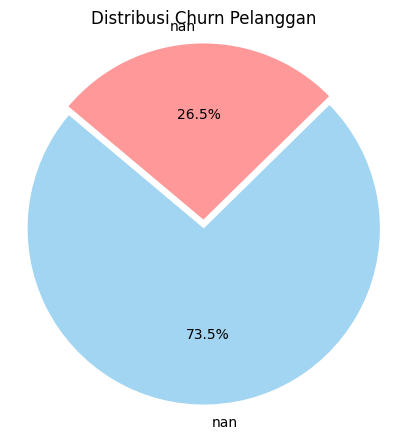

In [7]:
churn_counts = df['Churn'].value_counts()
churn_labels = churn_counts.index.map({0: 'Tidak Churn', 1: 'Churn'})  # ✅ tambahkan kurung tutup

plt.figure(figsize=(5, 5))
plt.pie(
    churn_counts,
    labels=churn_labels,  # ✅ gunakan churn_labels, bukan churn_counts
    autopct='%1.1f%%',
    startangle=140,
    colors=['#a2d5f2', '#ff9999'],  # Warna lembut pastel
    explode=(0, 0.05)  # sedikit keluar untuk efek visual Churn
)
plt.title('Distribusi Churn Pelanggan')
plt.axis('equal')  # Biar pie-nya bulat sempurna
plt.show()

Matriks Korelasi:
                SeniorCitizen    tenure  MonthlyCharges
SeniorCitizen        1.000000  0.016567        0.220173
tenure               0.016567  1.000000        0.247900
MonthlyCharges       0.220173  0.247900        1.000000


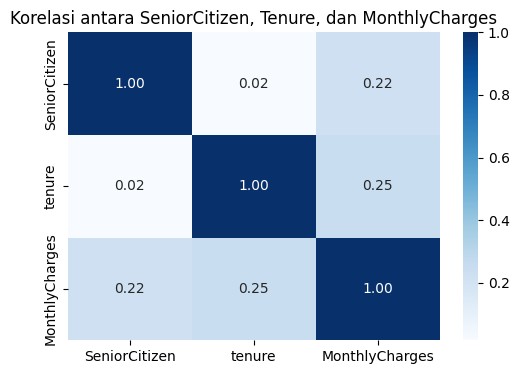

In [8]:
num_cols = ['SeniorCitizen', 'tenure', 'MonthlyCharges']
df_num = df[num_cols]

corr_matrix = df_num.corr(method='pearson')

print("Matriks Korelasi:")
print(corr_matrix)

plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Korelasi antara SeniorCitizen, Tenure, dan MonthlyCharges')
plt.show()

In [9]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Preprocessing

In [10]:
# Convert the 'TotalCharges' column to float type, coercing errors into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop the 'customerID' column since it is just an identifier
df.drop('customerID', axis=1, inplace=True)

# Encode binary categorical columns with values like Yes/No, Male/Female
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Female': 0, 'Male': 1})

# Apply one-hot encoding to multi-class categorical features
multi_cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                  'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=multi_cat_cols)

# Display the first few rows of the preprocessed DataFrame
print(df.head())

   gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  Churn  ...  \
0                 1           29.85         29.85      0  ...   
1                 0           56.95       1889.50      0  ...   
2                 1           53.85        108.15      1  ...   
3                 0           42.30       1840.75      0  ...   
4                 1           70.70        151.65      1  ...   

   StreamingMovies_No  StreamingMovies_No internet service  \
0                True                                False   
1                True                                False

In [11]:
scaler = StandardScaler()
num_cols = ['TotalCharges', 'MonthlyCharges', 'tenure']

df[num_cols] = scaler.fit_transform(df[num_cols])

print(df[num_cols].head())

   TotalCharges  MonthlyCharges    tenure
0     -0.994194       -1.160323 -1.277445
1     -0.173740       -0.259629  0.066327
2     -0.959649       -0.362660 -1.236724
3     -0.195248       -0.746535  0.514251
4     -0.940457        0.197365 -1.236724


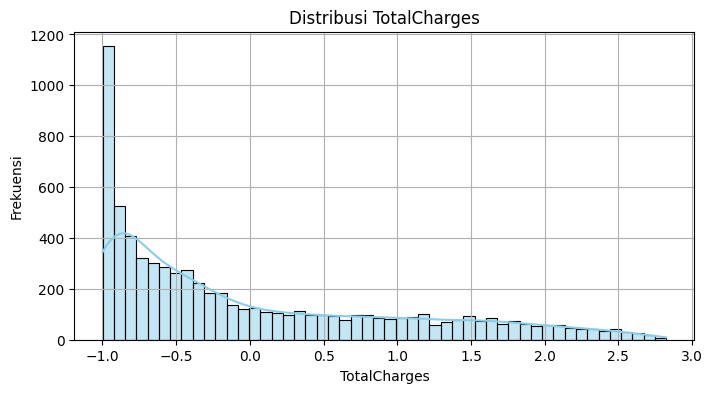

In [12]:
plt.figure(figsize=(8, 4))
sns.histplot(df['TotalCharges'], bins=50, kde=True, color='skyblue')
plt.title('Distribusi TotalCharges')
plt.xlabel('TotalCharges')
plt.ylabel('Frekuensi')
plt.grid(True)
plt.show()

In [13]:
median_total = df['TotalCharges'].median()
df['TotalCharges'].fillna(median_total, inplace=True)

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_20208\297114573.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(median_total, inplace=True)


In [14]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print(y_train_balanced.value_counts())

Churn
0    4138
1    4138
Name: count, dtype: int64


Modeling

In [15]:
pipeline = Pipeline(steps=[
    ('xgb', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[933 103]
 [170 203]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1036
           1       0.66      0.54      0.60       373

    accuracy                           0.81      1409
   macro avg       0.75      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [16]:
pipeline = Pipeline(steps=[
    ('xgb', XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])

pipeline.fit(X_train_balanced, y_train_balanced)

y_pred = pipeline.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[829 207]
 [ 86 287]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.80      0.85      1036
           1       0.58      0.77      0.66       373

    accuracy                           0.79      1409
   macro avg       0.74      0.78      0.76      1409
weighted avg       0.82      0.79      0.80      1409



Dalam Konteks Bisnis Churn, yang paling penting adalah mendeteksi siapa yang mau keluar (churn) ! maka digunakan model dengan smote

Production-grade data science

In [17]:
import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [18]:
binary_maps = {
    'gender': {'Female': 0, 'Male': 1},
    'Partner': {'No': 0, 'Yes': 1},
    'Dependents': {'No': 0, 'Yes': 1},
    'PhoneService': {'No': 0, 'Yes': 1},
    'PaperlessBilling': {'No': 0, 'Yes': 1},
    'Churn': {'No': 0, 'Yes': 1}
}

joblib.dump(binary_maps, 'binary_maps.pkl')

['binary_maps.pkl']

In [19]:
train_columns = X.columns.tolist()  # ✅ Betul!
joblib.dump(train_columns, 'artifacts/train_columns.pkl')

['artifacts/train_columns.pkl']

In [20]:
joblib.dump(pipeline, 'model.pkl')

['model.pkl']